<a href="https://colab.research.google.com/github/microprediction/PDCI/blob/master/COVID_US_Counties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import requests, json
import matplotlib.pyplot as plt

Joins census and covid case counts for US counties 

First we'll grab the county level data from the census. You can also try a pandas.read_csv directly if you like, though you'll have to be careful not to mangle the data and headings. 

In [4]:
census_data = requests.get('https://api.census.gov/data/2019/pep/population?get=DENSITY,POP,NAME&for=county:*').json()
headings = [ h.lower() for h in census_data[0]]
print(headings)
census = pd.DataFrame(columns=headings, data=census_data[1:])
census[:2]

['density', 'pop', 'name', 'state', 'county']


,density,pop,name,state,county
0,104.00162297,45756,"McDowell County, North Carolina",37,111
1,141.69366231,69685,"Franklin County, North Carolina",37,069


Next we will get some county level census data. Good luck here as the API is a bit wobbly in my experience. 

In [37]:
cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
cases[:3]

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0


In [28]:
len(cases)

310256

Poking around the case cound data a little ...

In [29]:
cases['county'].value_counts()

Washington    3321
Unknown       2977
Jefferson     2767
Franklin      2607
Jackson       2391
              ... 
Gilliam          5
Haakon           3
Kingman          3
Towner           2
Hickory          1
Name: county, Length: 1814, dtype: int64

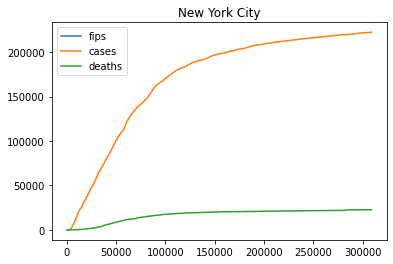

In [30]:
nyc = cases.loc[cases['county']=='New York City',:]
nyc.plot(title='New York City')


On the other hand...

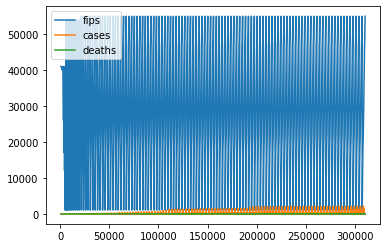

In [31]:
jackson = cases.loc[cases['county']=='Jackson',:]
jackson.plot()

So we should be a little careful. Let's include state in the name of the county and prepare to join with census data


In [38]:
cases['name'] = [ county+', '+state for county, state in zip(cases['county'].values,cases['state'].values)]
del cases['county']
del cases['state']
sorted_cases = cases[:len(cases)].sort_values(by=['name','date'],inplace=False)

If you just want the current situation, drop all be the last

In [39]:
recent_cases = sorted_cases.drop_duplicates(subset=['name'],keep='last')

In [40]:
recent_cases[:5]

,date,fips,cases,deaths,name
309440,2020-07-08,45001.0,137,1,"Abbeville, South Carolina"
308266,2020-07-08,22001.0,1094,44,"Acadia, Louisiana"
309935,2020-07-08,51001.0,1042,14,"Accomack, Virginia"
307711,2020-07-08,16001.0,3431,23,"Ada, Idaho"
307948,2020-07-08,19001.0,17,0,"Adair, Iowa"


In [41]:
len(recent_cases)

3118

Merge on county name

In [42]:
census['name'] = [ n.replace(' County','').replace(' Parish','') for n in census['name'].values]

In [43]:
census[:3]

,density,pop,name,state,county
0,104.00162297,45756,"McDowell, North Carolina",37,111
1,141.69366231,69685,"Franklin, North Carolina",37,069
2,264.5772215,209339,"Johnston, North Carolina",37,101


In [44]:
merged = recent_cases.merge(census,on=["name"])

In [45]:
merged[:4]

,date,fips,cases,deaths,name,density,pop,state,county
0,2020-07-08,45001.0,137,1,"Abbeville, South Carolina",49.909760456,24527,45,001
1,2020-07-08,22001.0,1094,44,"Acadia, Louisiana",94.700707541,62045,22,001
2,2020-07-08,51001.0,1042,14,"Accomack, Virginia",71.923561531,32316,51,001
3,2020-07-08,16001.0,3431,23,"Ada, Idaho",457.77677936,481587,16,001


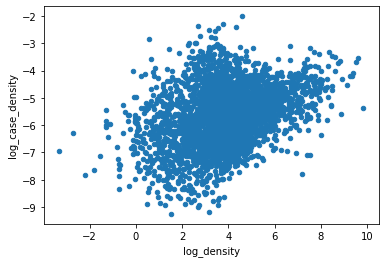

In [62]:
import math 
merged['log_case_density'] = merged['cases'].apply(lambda x: math.log(x)) - merged['pop'].apply(lambda x: math.log(float(x)))
merged['log_density'] = merged['density'].apply(lambda x: math.log(float(x)))
merged.plot.scatter(x='log_density',y='log_case_density')